![example](images/director_shot.jpeg)

# Project Title

**Authors:** Student 1, Student 2, Student 3
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [22]:
# Import Relevant Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image

# Neural network libraries

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, losses, metrics, Input
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
np.random.seed(42)

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [72]:
### Additional ideas
## Make fresh, new test set using IDG to split images in train directory into train/test/val
## Use augmentation on train set to make images more generalizable
## AAB: try multiclass problem to identify viral, bacteria, or none

In [2]:
# # Running in Google Colab
# from google.colab import drive

# drive.mount('/content/gdrive')
# root_path = 'gdrive/My Drive/Colab Notebooks/Pneumonia/' 

In [3]:
# Running locally
root_path = '../'

In [4]:
train_path = root_path + 'data/chest_xray/train/'
test_path = root_path + 'data/chest_xray/test/'

In [5]:
idg = ImageDataGenerator(rescale=1/255, validation_split=0.20)
train_set = idg.flow_from_directory(train_path, 
                                    target_size=(128, 128), 
                                    color_mode='grayscale', 
                                    class_mode='binary', 
                                    subset='training')
validation_set = idg.flow_from_directory(train_path, 
                                         target_size=(128, 128), 
                                         color_mode='grayscale', 
                                         class_mode='binary', 
                                         subset='validation')
test_set = idg.flow_from_directory(test_path, 
                                   target_size=(128,128), 
                                   color_mode='grayscale', 
                                   class_mode='binary', 
                                   shuffle=False)
# idg.flow()

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
classes = pd.DataFrame(train_set.classes)
class_dict = {0:'Normal', 1:'Pneumonia'}
classes[0] = classes[0].map(class_dict)
classes.value_counts()

Pneumonia    3100
Normal       1073
dtype: int64

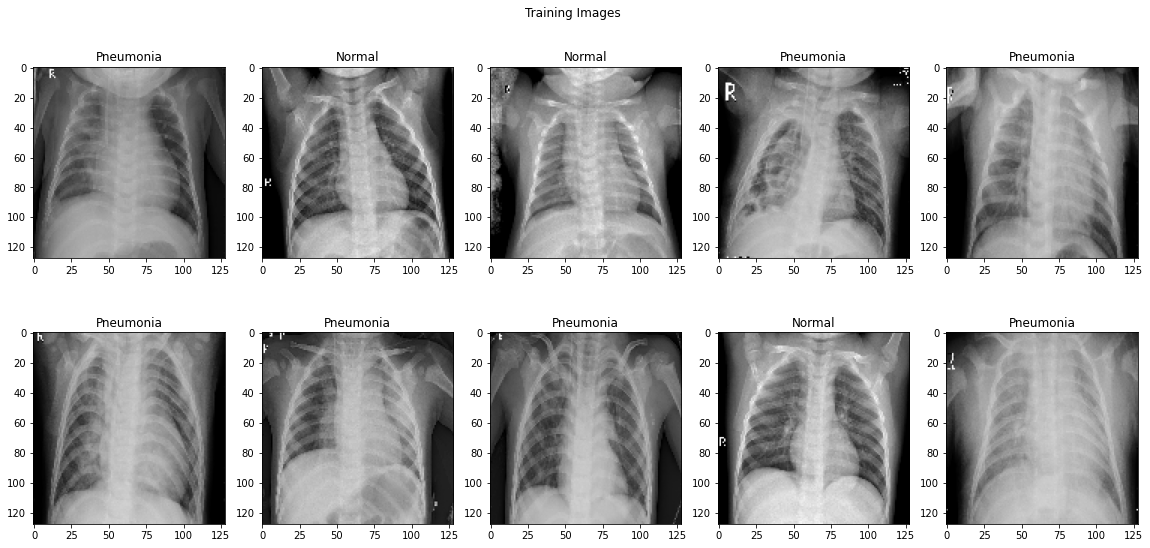

In [40]:
# # Visualize
train_images = train_set.next()
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

#train_images

for i in range(10):
    # Load image into numpy array and re-scale
    img = np.array(train_images[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5]
    ax.set_title(class_dict[train_images[1][i]])
    ax.imshow(img, cmap ='gray')
fig.suptitle('Training Images')
plt.tight_layout()
plt.show()

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### DummyClassifier

In [8]:
train_target_size = train_set.image_shape[0:2]
train_batch_size  = train_set.n

test_target_size  = test_set.image_shape[0:2]
test_batch_size   = test_set.n



# Batch size set to the number of images found above in order to not batch data for the dummy model. Validation set not needed for dummy model
train_set_dummy = idg.flow_from_directory(train_path,
                                          target_size=train_target_size,
                                          color_mode='grayscale', 
                                          class_mode='binary', 
                                          subset='training', 
                                          batch_size=train_batch_size)

test_set_dummy  = idg.flow_from_directory(test_path, 
                                          target_size=test_target_size,
                                          color_mode='grayscale',
                                          class_mode='binary',
                                          shuffle=False,
                                          batch_size=test_batch_size)

# Split train and test dummy sets into images and corresponding labels for dummy model training
train_images, train_labels = next(train_set_dummy)
test_images, test_labels = next(test_set_dummy)

Found 4173 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
baseline_model = DummyClassifier(strategy= 'most_frequent')
baseline_model.fit(train_images, train_labels)

DummyClassifier(strategy='most_frequent')

Baseline accuracy: 0.625
Baseline recall: 1.0


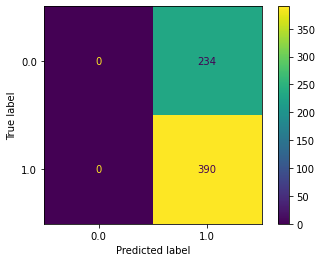

In [10]:
y_base_pred = baseline_model.predict(test_images)

base_accuracy = baseline_model.score(test_images, test_labels)
base_recall = recall_score(test_labels, y_base_pred)
print(f"Baseline accuracy: {base_accuracy}")
print(f"Baseline recall: {base_recall}")

plot_confusion_matrix(baseline_model, test_images, test_labels);

### First simple model

In [63]:
# here you run your code to model the data
simple_model = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 1)),
    layers.Dense(20, activation='sigmoid'),
    layers.Dense(12, activation='sigmoid'),
    layers.Dense(8, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])

# simple_model.add(Flatten(input_shape = (128, 128, 1)))
# simple_model.add(Dense(20, activation= 'sigmoid'))
# simple_model.add(Dense(12, activation= 'sigmoid'))
# simple_model.add(Dense(8, activation= 'sigmoid'))
# simple_model.add(Dense(1, activation='sigmoid'))

simple_model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])



In [64]:
results = simple_model.fit(train_set, #train_set_aug, 
                           epochs=100, 
                           batch_size=None, 
                           verbose=1, 
                           validation_data=validation_set)

Epoch 1/100
131/131 [==============================] - 43s 325ms/step - loss: 0.6308 - accuracy: 0.6861 - recall: 0.8752 - precision: 0.7461 - true_positives: 2713.0000 - true_negatives: 150.0000 - false_positives: 923.0000 - false_negatives: 387.0000 - auc: 0.5121 - val_loss: 0.5836 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.4935
Epoch 2/100
131/131 [==============================] - 41s 312ms/step - loss: 0.5759 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.5119 - val_loss: 0.5712 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 

131/131 [==============================] - 41s 315ms/step - loss: 0.5630 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.8474 - val_loss: 0.5628 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.8887
Epoch 18/100
131/131 [==============================] - 41s 315ms/step - loss: 0.5614 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.8946 - val_loss: 0.5615 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.9039

131/131 [==============================] - 41s 315ms/step - loss: 0.4931 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.9598 - val_loss: 0.4969 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.9341
Epoch 34/100
131/131 [==============================] - 41s 314ms/step - loss: 0.4832 - accuracy: 0.7429 - recall: 1.0000 - precision: 0.7429 - true_positives: 3100.0000 - true_negatives: 0.0000e+00 - false_positives: 1073.0000 - false_negatives: 0.0000e+00 - auc: 0.9618 - val_loss: 0.4874 - val_accuracy: 0.7430 - val_recall: 1.0000 - val_precision: 0.7430 - val_true_positives: 775.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 268.0000 - val_false_negatives: 0.0000e+00 - val_auc: 0.9367

131/131 [==============================] - 42s 320ms/step - loss: 0.2574 - accuracy: 0.9396 - recall: 0.9784 - precision: 0.9425 - true_positives: 3033.0000 - true_negatives: 888.0000 - false_positives: 185.0000 - false_negatives: 67.0000 - auc: 0.9806 - val_loss: 0.2814 - val_accuracy: 0.9185 - val_recall: 0.9535 - val_precision: 0.9378 - val_true_positives: 739.0000 - val_true_negatives: 219.0000 - val_false_positives: 49.0000 - val_false_negatives: 36.0000 - val_auc: 0.9678
Epoch 50/100
131/131 [==============================] - 42s 318ms/step - loss: 0.2445 - accuracy: 0.9403 - recall: 0.9742 - precision: 0.9470 - true_positives: 3020.0000 - true_negatives: 904.0000 - false_positives: 169.0000 - false_negatives: 80.0000 - auc: 0.9812 - val_loss: 0.2703 - val_accuracy: 0.9175 - val_recall: 0.9458 - val_precision: 0.9434 - val_true_positives: 733.0000 - val_true_negatives: 224.0000 - val_false_positives: 44.0000 - val_false_negatives: 42.0000 - val_auc: 0.9693
Epoch 51/100
131/131 [=

Epoch 66/100
131/131 [==============================] - 41s 314ms/step - loss: 0.1434 - accuracy: 0.9578 - recall: 0.9723 - precision: 0.9710 - true_positives: 3014.0000 - true_negatives: 983.0000 - false_positives: 90.0000 - false_negatives: 86.0000 - auc: 0.9890 - val_loss: 0.1755 - val_accuracy: 0.9291 - val_recall: 0.9355 - val_precision: 0.9680 - val_true_positives: 725.0000 - val_true_negatives: 244.0000 - val_false_positives: 24.0000 - val_false_negatives: 50.0000 - val_auc: 0.9824
Epoch 67/100
131/131 [==============================] - 41s 315ms/step - loss: 0.1403 - accuracy: 0.9561 - recall: 0.9713 - precision: 0.9697 - true_positives: 3011.0000 - true_negatives: 979.0000 - false_positives: 94.0000 - false_negatives: 89.0000 - auc: 0.9890 - val_loss: 0.1745 - val_accuracy: 0.9281 - val_recall: 0.9329 - val_precision: 0.9692 - val_true_positives: 723.0000 - val_true_negatives: 245.0000 - val_false_positives: 23.0000 - val_false_negatives: 52.0000 - val_auc: 0.9825
Epoch 68/100

Epoch 83/100
131/131 [==============================] - 41s 314ms/step - loss: 0.1122 - accuracy: 0.9633 - recall: 0.9758 - precision: 0.9749 - true_positives: 3025.0000 - true_negatives: 995.0000 - false_positives: 78.0000 - false_negatives: 75.0000 - auc: 0.9912 - val_loss: 0.1549 - val_accuracy: 0.9396 - val_recall: 0.9445 - val_precision: 0.9734 - val_true_positives: 732.0000 - val_true_negatives: 248.0000 - val_false_positives: 20.0000 - val_false_negatives: 43.0000 - val_auc: 0.9845
Epoch 84/100
131/131 [==============================] - 41s 316ms/step - loss: 0.1126 - accuracy: 0.9626 - recall: 0.9742 - precision: 0.9755 - true_positives: 3020.0000 - true_negatives: 997.0000 - false_positives: 76.0000 - false_negatives: 80.0000 - auc: 0.9919 - val_loss: 0.1559 - val_accuracy: 0.9415 - val_recall: 0.9742 - val_precision: 0.9485 - val_true_positives: 755.0000 - val_true_negatives: 227.0000 - val_false_positives: 41.0000 - val_false_negatives: 20.0000 - val_auc: 0.9852
Epoch 85/100

Epoch 100/100
131/131 [==============================] - 41s 315ms/step - loss: 0.1014 - accuracy: 0.9674 - recall: 0.9781 - precision: 0.9781 - true_positives: 3032.0000 - true_negatives: 1005.0000 - false_positives: 68.0000 - false_negatives: 68.0000 - auc: 0.9920 - val_loss: 0.2048 - val_accuracy: 0.9300 - val_recall: 0.9871 - val_precision: 0.9239 - val_true_positives: 765.0000 - val_true_negatives: 205.0000 - val_false_positives: 63.0000 - val_false_negatives: 10.0000 - val_auc: 0.9853


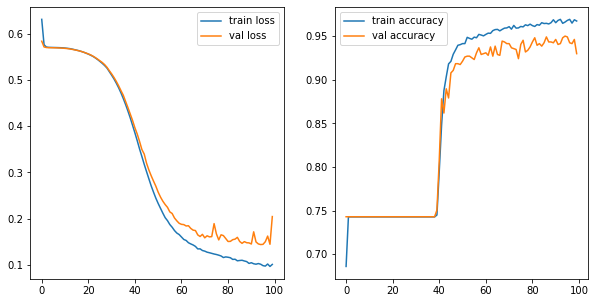

In [69]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']
val_loss = results.history['val_loss']
val_accuracy = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='train loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='train accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val loss')
sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label='val accuracy')
ax1.legend();

In [70]:
simple_model.evaluate(test_set)

20/20 [==============================] - 4s 182ms/step - loss: 1.1119 - accuracy: 0.6971 - recall: 0.9949 - precision: 0.6748 - true_positives: 388.0000 - true_negatives: 47.0000 - false_positives: 187.0000 - false_negatives: 2.0000 - auc: 0.8714


[1.1118611097335815,
 0.6971153616905212,
 0.9948717951774597,
 0.6747826337814331,
 388.0,
 47.0,
 187.0,
 2.0,
 0.871405839920044]

In [66]:
output_path = root_path + 'data/simple_model.h5'
simple_model.save(output_path)

In [55]:
# here you run your code to model the data
simple_model_v2 = models.Sequential([
    layers.Input(shape=(128, 128, 1)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(320, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

simple_model_v2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'AUC'])

simple_model_v2.output_shape

(None, 1)

In [56]:
results_v2 = simple_model_v2.fit(train_set, #train_set_aug, 
                           epochs=50, 
                           batch_size=32, 
                           validation_data=validation_set)

Epoch 1/50
131/131 [==============================] - 44s 335ms/step - loss: 0.4904 - accuracy: 0.8016 - recall: 0.9261 - precision: 0.8274 - true_positives: 2871.0000 - true_negatives: 474.0000 - false_positives: 599.0000 - false_negatives: 229.0000 - auc: 0.8184 - val_loss: 0.2862 - val_accuracy: 0.8878 - val_recall: 0.9806 - val_precision: 0.8817 - val_true_positives: 760.0000 - val_true_negatives: 166.0000 - val_false_positives: 102.0000 - val_false_negatives: 15.0000 - val_auc: 0.9432
Epoch 2/50
131/131 [==============================] - 43s 326ms/step - loss: 0.2193 - accuracy: 0.9180 - recall: 0.9510 - precision: 0.9395 - true_positives: 2948.0000 - true_negatives: 883.0000 - false_positives: 190.0000 - false_negatives: 152.0000 - auc: 0.9587 - val_loss: 0.1937 - val_accuracy: 0.9252 - val_recall: 0.9781 - val_precision: 0.9255 - val_true_positives: 758.0000 - val_true_negatives: 207.0000 - val_false_positives: 61.0000 - val_false_negatives: 17.0000 - val_auc: 0.9721
Epoch 3/50


Epoch 18/50
131/131 [==============================] - 41s 313ms/step - loss: 0.1030 - accuracy: 0.9583 - recall: 0.9729 - precision: 0.9710 - true_positives: 3016.0000 - true_negatives: 983.0000 - false_positives: 90.0000 - false_negatives: 84.0000 - auc: 0.9907 - val_loss: 0.1423 - val_accuracy: 0.9463 - val_recall: 0.9703 - val_precision: 0.9580 - val_true_positives: 752.0000 - val_true_negatives: 235.0000 - val_false_positives: 33.0000 - val_false_negatives: 23.0000 - val_auc: 0.9860
Epoch 19/50
131/131 [==============================] - 40s 305ms/step - loss: 0.0857 - accuracy: 0.9693 - recall: 0.9823 - precision: 0.9766 - true_positives: 3045.0000 - true_negatives: 1000.0000 - false_positives: 73.0000 - false_negatives: 55.0000 - auc: 0.9934 - val_loss: 0.2170 - val_accuracy: 0.9214 - val_recall: 0.9032 - val_precision: 0.9901 - val_true_positives: 700.0000 - val_true_negatives: 261.0000 - val_false_positives: 7.0000 - val_false_negatives: 75.0000 - val_auc: 0.9845
Epoch 20/50
13

Epoch 35/50
131/131 [==============================] - 43s 327ms/step - loss: 0.0547 - accuracy: 0.9811 - recall: 0.9881 - precision: 0.9865 - true_positives: 3063.0000 - true_negatives: 1031.0000 - false_positives: 42.0000 - false_negatives: 37.0000 - auc: 0.9975 - val_loss: 0.4552 - val_accuracy: 0.8629 - val_recall: 0.9948 - val_precision: 0.8473 - val_true_positives: 771.0000 - val_true_negatives: 129.0000 - val_false_positives: 139.0000 - val_false_negatives: 4.0000 - val_auc: 0.9560
Epoch 36/50
131/131 [==============================] - 43s 327ms/step - loss: 0.0732 - accuracy: 0.9732 - recall: 0.9829 - precision: 0.9810 - true_positives: 3047.0000 - true_negatives: 1014.0000 - false_positives: 59.0000 - false_negatives: 53.0000 - auc: 0.9949 - val_loss: 0.1518 - val_accuracy: 0.9463 - val_recall: 0.9561 - val_precision: 0.9712 - val_true_positives: 741.0000 - val_true_negatives: 246.0000 - val_false_positives: 22.0000 - val_false_negatives: 34.0000 - val_auc: 0.9867
Epoch 37/50


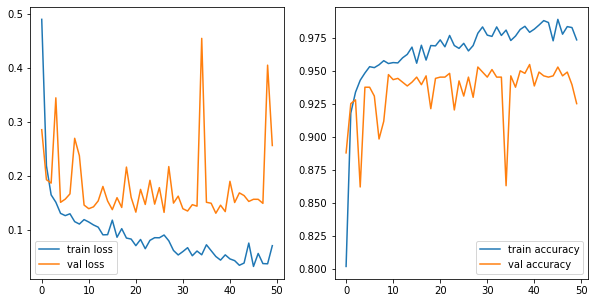

In [62]:
sigmoid_loss = results_v2.history['loss']
sigmoid_accuracy = results_v2.history['accuracy']
val_loss = results_v2.history['val_loss']
val_accuracy = results_v2.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results_v2.epoch, y=sigmoid_loss, ax=ax1, label='train loss')
sns.lineplot(x=results_v2.epoch, y=sigmoid_accuracy, ax=ax2, label='train accuracy')
sns.lineplot(x=results_v2.epoch, y=val_loss, ax=ax1, label='val loss')
sns.lineplot(x=results_v2.epoch, y=val_accuracy, ax=ax2, label='val accuracy')
ax1.legend();

In [71]:
simple_model_v2.evaluate(test_set)

20/20 [==============================] - 4s 189ms/step - loss: 0.5858 - accuracy: 0.8333 - recall: 0.9513 - precision: 0.8136 - true_positives: 371.0000 - true_negatives: 149.0000 - false_positives: 85.0000 - false_negatives: 19.0000 - auc: 0.9077


[0.5858463048934937,
 0.8333333134651184,
 0.9512820243835449,
 0.8135964870452881,
 371.0,
 149.0,
 85.0,
 19.0,
 0.9077361226081848]

In [59]:
output_path = root_path + 'data/simple_model_v2.h5'
simple_model_v2.save(output_path)

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***